In [40]:
from code.data_processing import add_ti
from code.apiwrappers import BinanceWrapper
from code.charting import chart_to_image, chart_to_arr
from PIL import Image

import torch

import pandas as pd

In [5]:
bw = BinanceWrapper('5lJ0uGit9PuUxHka3hBWhPmsi7dWyxEwvEntUZFKmm0xfNz3VjHWi5WSr5W1VBJV',
                                                      'BFWVs8ko7Cd4sjdQ9amGJTnToGWy9TbQWIjeorSCj23FGiwFaknzkgLPcrgWrxsw')

In [ ]:
# Fetch stats from Binance
candles = bw.historical_candles(start_time='January 1 2019', end_time='June 1 2019', symbol='ETHBTC', interval='1m')

In [7]:
# We'll save the candles to csv as requesting it from Binance takes a lot of time
candles.to_csv('bitcoin1m-GOOD.csv', index=False)

In [10]:
# Read from saved csv instead of fetching it all the time
candles_csv = pd.read_csv('bitcoin1m-GOOD.csv', engine='python')[150000:]

In [8]:
print(candles.count)

<bound method DataFrame.count of                 time      open     close      high       low   volume
0       1.546301e+12  0.035534  0.035513  0.035558  0.035510  388.941
1       1.546301e+12  0.035521  0.035488  0.035521  0.035477   73.726
2       1.546301e+12  0.035498  0.035495  0.035504  0.035471   55.949
3       1.546301e+12  0.035495  0.035495  0.035543  0.035472   54.777
4       1.546301e+12  0.035506  0.035496  0.035539  0.035471   63.162
...              ...       ...       ...       ...       ...      ...
216476  1.559347e+12  0.031249  0.031297  0.031298  0.031241  135.250
216477  1.559347e+12  0.031288  0.031286  0.031291  0.031266   99.446
216478  1.559347e+12  0.031280  0.031332  0.031339  0.031280  172.482
216479  1.559347e+12  0.031338  0.031314  0.031343  0.031301   96.830
216480  1.559347e+12  0.031314  0.031357  0.031366  0.031290  547.397

[216481 rows x 6 columns]>


In [16]:
print(candles_csv.count)

<bound method DataFrame.count of                time      open     close      high       low   volume
0      1.557122e+12  0.028191  0.028185  0.028195  0.028184   90.836
1      1.557122e+12  0.028186  0.028176  0.028186  0.028173   64.269
2      1.557123e+12  0.028175  0.028182  0.028185  0.028172   21.056
3      1.557123e+12  0.028180  0.028180  0.028185  0.028169   57.869
4      1.557123e+12  0.028178  0.028173  0.028179  0.028169   26.023
...             ...       ...       ...       ...       ...      ...
36476  1.559347e+12  0.031249  0.031297  0.031298  0.031241  135.250
36477  1.559347e+12  0.031288  0.031286  0.031291  0.031266   99.446
36478  1.559347e+12  0.031280  0.031332  0.031339  0.031280  172.482
36479  1.559347e+12  0.031338  0.031314  0.031343  0.031301   96.830
36480  1.559347e+12  0.031314  0.031357  0.031366  0.031290  547.397

[36481 rows x 6 columns]>


In [13]:
candles_csv = candles_csv[30000:]

In [15]:
candles_csv = candles_csv.reset_index(drop=True)

In [28]:
candles_csv.head()

,time,open,close,high,low,volume,sma20,macd,obv,bb20_low,bb20_mid,bb20_up
30024,1.548102e+12,0.032920,0.032916,0.032928,0.032915,56.229,0.032928,0.130141,-320.430,0.032908,0.032928,0.032948
30025,1.548102e+12,0.032920,0.032911,0.032920,0.032904,38.826,0.032927,0.105453,-359.256,0.032907,0.032927,0.032948
30026,1.548102e+12,0.032909,0.032908,0.032911,0.032904,36.945,0.032926,0.082505,-396.201,0.032905,0.032926,0.032948
30027,1.548102e+12,0.032905,0.032905,0.032909,0.032896,41.615,0.032925,0.061196,-437.816,0.032902,0.032925,0.032947
30028,1.548102e+12,0.032905,0.032902,0.032913,0.032896,66.353,0.032923,0.041425,-504.169,0.032900,0.032923,0.032945


In [22]:
candles_csv.shape

(186481, 6)

In [27]:
candles_csv = add_ti(candles_csv)

In [29]:
def split_candles(df, num_rows=30, step=10):
    """Split a DataFrame of candlestick data into a list of smaller DataFrames each with num_rows rows"""
    
    slices = []
    
    for row_i in range(0, df.shape[0] - num_rows, step):
        small_df = df.iloc[row_i:row_i+num_rows, :]
        slices.append(small_df)
        
    return slices

In [30]:
def price_returns(df, num_rows=30, num_into_fut=5, step=10):
    labels = []
    
    for row_i in range(0, df.shape[0] - num_rows - num_into_fut, step):
        # skip all iterations while row_i < num_rows since nothing yet to create a label for
        if row_i <= num_rows: continue
        
        vf, vi = df['close'][row_i+num_into_fut], df['close'][row_i]
        price_return = (vf - vi) / vi
        labels.append(price_return)
    return labels

In [31]:
def create_charts(candles_sliced, save_path):
    """Create a chart image for each in sliced_candles and return a list of paths to those images"""
    from tqdm import tqdm_notebook as tqdm
    import warnings
    warnings.filterwarnings("ignore")
    
    i = 0
    paths_to_images = []
    for small_df in tqdm(candles_sliced):
        chart = Charting(small_df, 'time', 'close')
        
        path = save_path + 'chart_{}.png'.format(i)
        chart.chart_to_image(path)
        paths_to_images.append(path)
        i += 1
    return paths_to_images        

In [26]:
from code.datasets import DFDataset, ChartImageDataset
from torch.utils.data import *

In [32]:
candles_sliced = split_candles(candles_csv)

In [45]:
chart_to_image(candles_sliced[0], 'images/image1.png')

In [36]:
paths_to_images = create_charts(candles_sliced, "images/")

NameError: name 'Charting' is not defined

In [37]:
 paths_to_images = [ 'images/chart_{}.png'.format(i) for i in range(len(candles_sliced)) ]

In [41]:
candles_test = pd.read_csv('tests/sample_candles.csv')

In [42]:
chart_to_image(candles_test, 'tests/test_image2.png')

In [ ]:
# Image.open(paths_to_images[103])

In [27]:
price_returnz = price_returns(candles.reset_index(drop=True))

In [28]:
def normalize_series(ser):
    return (ser-ser.min())/(ser.max()-ser.min())

In [29]:
try: candles = candles.drop('time', axis=1).reset_index(drop=True)
except: pass
candles.shape

(196556, 11)

In [30]:
candles = candles.apply(normalize_series, axis=0)
candles.shape

(196556, 11)

In [31]:
# split candles into 30 period and a label
candles_sliced = split_candles(candles)
# we need to remove candle slices without a label from candles_sliced
candles_sliced = candles_sliced[len(candles_sliced)-len(price_returnz):]

assert len(candles_sliced) == len(price_returnz)
len(candles_sliced)

19649

In [30]:
candles.head()

,open,high,low,close,volume,sma20,macd,obv,bb20_low,bb20_mid,bb20_up
0,0.019138,0.018738,0.026598,0.026577,0.000065,0.018367,0.981661,0.971387,0.018940,0.018367,0.018318
1,0.019016,0.018616,0.026598,0.026577,0.000094,0.018369,0.981660,0.971387,0.018944,0.018369,0.018317
2,0.019138,0.018738,0.026598,0.026577,0.000035,0.018366,0.981660,0.971387,0.018941,0.018366,0.018314
3,0.019138,0.018738,0.026598,0.026577,0.000035,0.018368,0.981660,0.971387,0.018944,0.018368,0.018314
4,0.019138,0.018738,0.026598,0.026577,0.000035,0.018369,0.981660,0.971387,0.018948,0.018369,0.018313


In [32]:
import torch
torch.backends.cudnn.benchmark = True

# Parameters
params = {'batch_size': 64,
          'shuffle': True,
          'num_workers': 1}

In [33]:
def _train(train_gen, model, optim, error_func):
    losses = []
    
    for batch, labels in train_gen:    
        batch, labels = batch.float(), labels.float()
        # set model to train mode
        model.train()
        
        # clear gradients
        model.zero_grad()
        
        output = model(batch)
        loss = error_func(output, labels)
        loss.backward()
        optim.step()
        
        
        losses.append(loss)
        
    return round(float(sum(losses) / len(losses)), 6)

In [34]:
def _valid(valid_gen, model, optim, error_func):
    with torch.set_grad_enabled(False):
        losses = []

        for batch, labels in valid_gen:
            batch, labels = batch.float(), labels.float()
            
            # set to eval mode
            model.eval()
            
            # clear gradients
            model.zero_grad()

            output = model(batch)
            loss = error_func(output, labels)

            losses.append(loss)
        
    return round(float(sum(losses) / len(losses)), 6)

In [35]:
def _test(test_gen, model, optim, error_func):
    with torch.set_grad_enabled(False):
        losses = []

        for batch, labels in valid_gen:
            batch, labels = batch.float(), labels.float()
            
            # set to eval mode
            model.eval()
            
            # clear gradients
            model.zero_grad()

            output = model(batch)
            loss = error_func(output, labels)

            losses.append(loss)
        
    return round(float(sum(losses) / len(losses)), 6)

In [36]:
def train(model, model_name, optim, num_epochs, train_gen, valid_gen, test_gen=None):
    """Train a PyTorch model with optim as optimizer strategy"""
    
    for epoch_i in range(num_epochs):
        
        
        def RMSE(x, y):
            
            # have to squish x into a rank 1 tensor with batch_size length with the outputs we want
            if model_name == 'resnet':
                 # torch.Size([64, 1])
                x = x.squeeze(1)
            elif model_name == 'gru':
                # torch.Size([64, 30, 1])
                x = x[:, 29, :] # take only the last prediction from the 30 time periods in our matrix
                x = x.squeeze(1)
    
            mse = torch.nn.MSELoss()
            return torch.sqrt(mse(x, y))
        
        
        # forward and backward passes of all batches inside train_gen
        train_loss = _train(train_gen, model, optim, RMSE)
        valid_loss = _valid(valid_gen, model, optim, RMSE)
        
        # run on test set if provided
        if test_gen: test_output = _test(test_gen, model, optim)
        else: test_output = "no test selected"
        print("train loss: {}, valid loss: {}, test output: {}".format(train_loss, valid_loss, test_output))

In [40]:
from code.models import CNN
cnn = CNN().float()

KeyError: 'time'

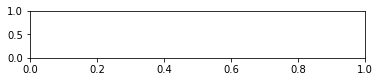

In [44]:
# create dataloaders
# specify the split between train_df and valid_df from the process of splitting dataset_windows 
split = 0.7

s = int(len(candles_sliced) * 0.7)
while s % params['batch_size'] != 0:
    s += 1

# create two ChartImageDatasets, split by split, for the purpose of creating a DataLoader for the specific model
train_ds_cnn = ChartImageDataset(candles_sliced[:s], price_returnz[:s])
valid_ds_cnn = ChartImageDataset(candles_sliced[s:], price_returnz[s:])

train_gen_cnn = DataLoader(train_ds_cnn, drop_last=True, **params)
valid_gen_cnn = DataLoader(valid_ds_cnn, drop_last=True, **params)

In [ ]:
train(cnn, 'resnet', torch.optim.Adam(cnn.parameters(), 1e-3), 8, train_gen_cnn, valid_gen_cnn)

In [ ]:
from helpers.saving_models import save_model, load_model

save_model(cnn, 'cnn_weights')

In [41]:
# create dataloaders
# specify the split between train_df and valid_df from the process of splitting dataset_windows 
split = 0.7

s = int(len(candles_sliced) * 0.7)
while s % params['batch_size'] != 0:
    s += 1
print(s)

# create two ChartImageDatasets, split by split, for the purpose of creating a DataLoader for the specific model
train_ds_gru = DFTimeSeriesDataset(candles_sliced[:s], price_returnz[:s])
valid_ds_gru = DFTimeSeriesDataset(candles_sliced[s:], price_returnz[s:])
train_gen_gru = DataLoader(train_ds_gru, **params, drop_last=True)
valid_gen_gru = DataLoader(valid_ds_gru, **params, drop_last=True)

145856


In [42]:
from models.GRU.GRU import GRUnet

gru = GRUnet(11, 30, 64, 500, 3).cuda()

In [43]:
train(gru, 'gru', torch.optim.Adam(gru.parameters(), 1e-3), 4, train_gen_gru, valid_gen_gru)

OSError: [Errno 12] Cannot allocate memory

In [ ]:
from helpers.saving_models import save_model, load_model

save_model(gru, 'gru_weights')

In [7]:
from BackTest import BackTest

In [ ]:
from models.GRU.GRU import GRUnet
gru = GRUnet(num_features=11, num_rows=30, batch_size=1, hidden_size=50, num_layers=5, eval_mode=False).float().cuda()

In [9]:
from models.CNN.CNN import CNN
cnn = CNN().cuda().float()

In [10]:
from helpers.saving_models import load_model
load_model(cnn, 'cnn_weights')

In [12]:
from strategies.example_strategies import RNNStrat, CNNStrat
strat = CNNStrat(cnn)

In [13]:
b = BackTest(strat)

KeyboardInterrupt: 

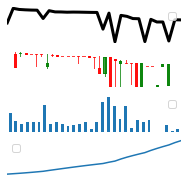

In [15]:
b.profit_test(candles.reset_index(drop=True), model_type="cnn")